# Ingest Image Data
When working on computer vision tasks, you may be using a common library such as OpenCV, matplotlib, or pandas. Once we are moving to cloud and start your machine learning journey in Amazon Sagemaker, you will facing new challenges of loading, reading and writing files from S3 to a Sagemaker Notebook, and we will discuss several appraoches in this section. Due to the size of the data we are dealing with, copying data into the instance is not recommended; you do not need to download data to the Sagemaker to train a model either. But if you want to take a look at a few samples from the image dataset and decide whether any transformation/pre-processing is needed, here are ways to do it.

### Image data: COCO (Common Objects in Context)
 **COCO** is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:

* Object segmentation
* Recognition in context
* Superpixel stuff segmentation
* 330K images (>200K labeled)
* 1.5 million object instances
* 80 object categories
* 91 stuff categories
* 5 captions per image
* 250,000 people with keypoints

## Download image data and write to S3
**Note**: COCO data size is large so this could take some time. You can download partial files by using [COCOAPI](https://github.com/cocodataset/cocoapi).

In [ ]:
# public data source location
public_path_coco = 's3://open-images-dataset/test'
# private destination location
private_path_image = 's3://{}/image_coco'.format(bucket)
# copy data to S3
!aws s3 cp --recursive $public_path_coco/ $private_path_image/ --only-show-errors --no-progress

## Set Up Notebook

In [2]:
import io
import boto3
import sagemaker
from sagemaker import get_execution_role
import json

# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = 'sagemaker-us-east-1-942158337222'
 # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
role = get_execution_role()
prefix = 'image_coco'
filename = '000026e7ee790996.jpg'

## Method 1: Streaming data from S3 to the SageMaker instance-memory 

  **Use AWS compatible Python Packages with io Module** 
 
The easiest way to access your files in S3 without copying files into your instance storage is to use pre-built packages which already have implemented options to access data with a specified path string. Streaming means to read the object directly to memory instead of writing it to a file. As an example the `matplotlib` library has a pre-built function `imread` that usually an URL or path to a image, but here we use S3 objects and BytesIO method to read the image. You can also go with `PIL` package.

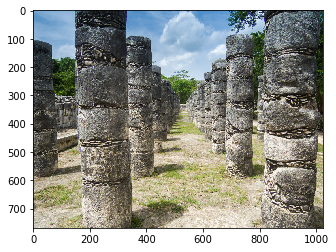

In [9]:
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

key = "{}/{}".format(prefix,filename)
image_object =  boto3.resource('s3').Bucket(bucket).Object(key)
image = mpimage.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')

plt.figure(0)
plt.imshow(image)

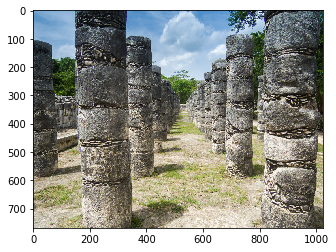

In [13]:
from PIL import Image
im = Image.open(image_object.get()['Body'])
plt.figure(0)
plt.imshow(im)

In [ ]:
import scipy.io as io
mat = io.loadmat(img_path.replace('.jpg','.mat'))

## Method 2: Using temporary files on the SageMaker instance
Another way to work with your usual methods is to create temporary files on your SageMaker instance and feed them into the standard methods as a file path. Tempfiles provides automatic cleanup, meaning that creates temporary files that will be deleted as file is closed 

(768, 1024, 3)


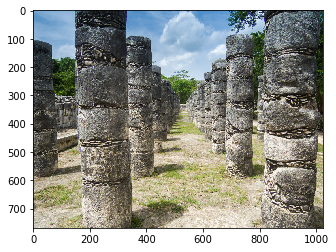

In [14]:
import tempfile
tmp = tempfile.NamedTemporaryFile()
with open(tmp.name, 'wb') as f:
    image_object.download_fileobj(f)
    f.seek(0,2) # the file will be downloaded in a lazy fashion, so add this to the file descriptor
    img = plt.imread(tmp.name)
    print (img.shape)
    plt.imshow(im)

## Method 3: Use AWS native methods
#### s3fs 
[S3Fs](https://s3fs.readthedocs.io/en/latest/) is a Pythonic file interface to S3. It builds on top of botocore. The top-level class S3FileSystem holds connection information and allows typical file-system style operations like cp, mv, ls, du, glob, etc., as well as put/get of local files to/from S3.

In [49]:
!pip install -q s3fs==0.4.2

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [20]:
import s3fs
#fs = s3fs.S3FileSystem()
#data_s3fs_location = "s3://{}/{}/".format(bucket, prefix)
# To List first file in your accessible bucket
fs.ls(data_s3fs_location)[0]

'sagemaker-us-east-1-942158337222/image_coco/000026e7ee790996.jpg'

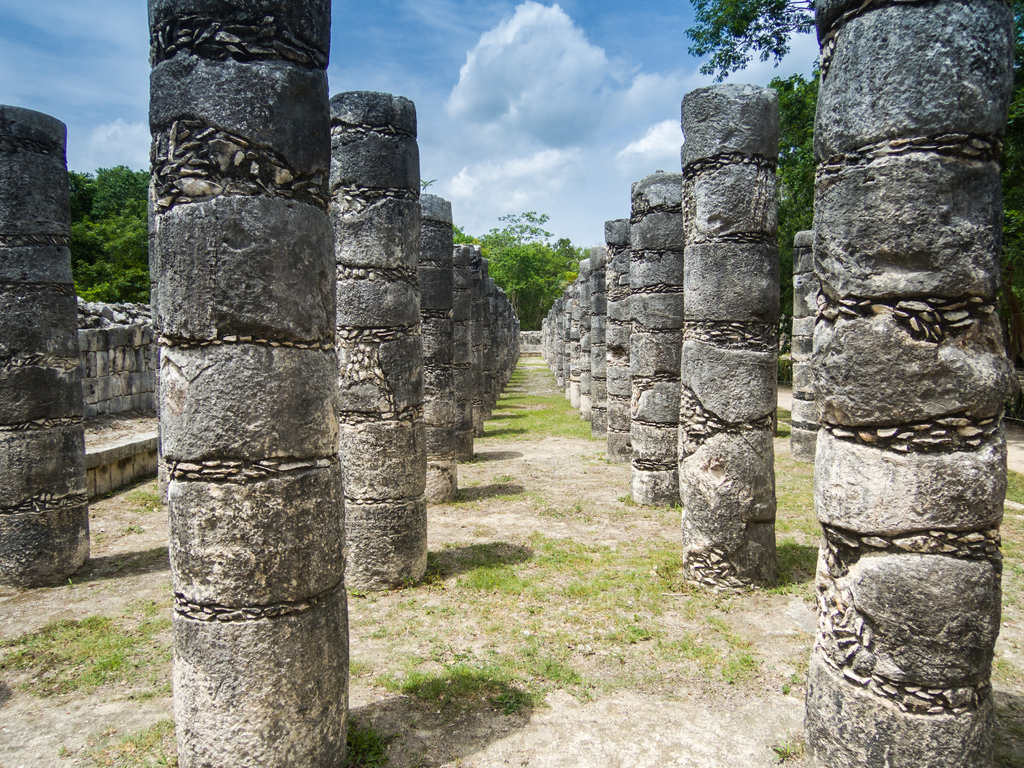

In [21]:
# open it directly with s3fs
data_s3fs_location = "s3://{}/{}/{}".format(bucket, prefix, filename) # S3 URL
with fs.open(data_s3fs_location) as f:
    display(Image.open(f))